# Developed by Gaurav Arora, Ph.D. 

## (Google Scholar: https://scholar.google.com/citations?user=odZBkmMAAAAJ&hl=en) and (LinkedIn: www.linkedin.com/in/gaurav-arora-1100

### Code for training the convolutional neural network (CNN) for predicting stacking fault energies from charge density images
#### Importing all the relevant modules

In [1]:
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from keras.models import load_model
from sklearn.metrics import r2_score
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import visualkeras as vk
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import time
import cv2
import os

np.random.seed(54) #Chosing any random seed

#### Fetching the target SFE values from excel sheet

In [2]:
target_data = pd.read_excel('SFE_information.xlsx', sheet_name = 'SFEs')
SFEs = np.array(target_data['SFEs'])

#### Fetching the images from a given folder and converting them in the form read by machine learning model

In [3]:
path = r'CHGCAR_images' #Name or the path of the folder contaning images

os.chdir(str(path)) #Changing the directory to the folder containing images
data_all_images = [] #defining an empty array for storing all the image data
for i in range (1, 138): #looping through all the images in folder, input the number of images being used
    img_read = cv2.imread('CHGCAR-' + str(i) + '.png') #Reading png file format
    dim = (196,73) # original = 146* 392 #Reducing the dimension of each image for easy processing
    resized_img = cv2.resize(img_read, dim, interpolation = cv2.INTER_AREA)
    data_all_images.append(resized_img) #Appending the images in an empty array

data_all_images_array = np.array(data_all_images) / 255.0 #Reformatting the image data to array form and dividing it by 255 for normalizing
shape_of_images_data_all = np.shape(data_all_images_array)

#### Spliting the data into training, testing and holdout dataset

In [4]:
train_desc, test_desc, train_target, test_target = tts(data_all_images_array, SFEs, test_size = 0.2, random_state = 54, shuffle = True)
test_desc, hold_desc, test_target, hold_target = tts(test_desc,test_target, test_size = 0.5, random_state = 54, shuffle = True)
print(f'The length of training, testing, and holout dataset is: {len(train_target)} {len(test_target)} {len(hold_target)} respectively')

The length of training, testing, and holout dataset is: 109 14 14 respectively


#### Building the infrastructure for the CNN model. Defining parameters such as number of layers, kernal size, activation functions.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


2022-10-09 07:01:32.788453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 73, 196, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 72, 195, 32)       416       
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 194, 64)       8256      
                                                                 
 average_pooling2d (AverageP  (None, 35, 97, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 96, 96)        24672     
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 95, 128)       49280     
                                                             

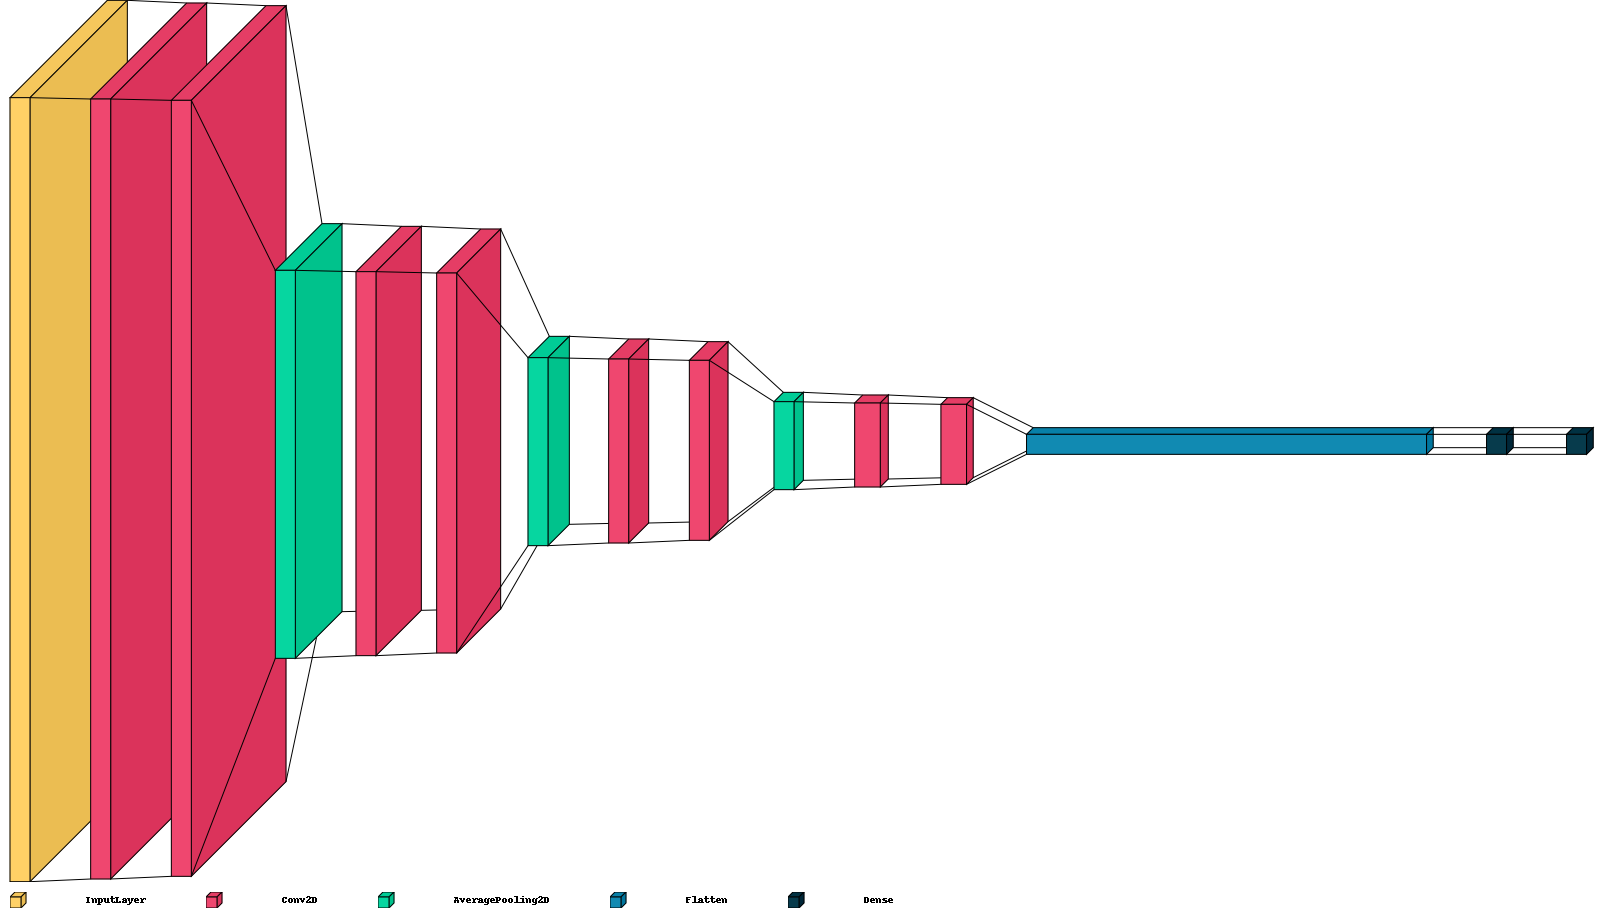

In [5]:
def build_and_compile_model():
    input_layer = keras.Input(shape = (shape_of_images_data_all[1], shape_of_images_data_all[2], shape_of_images_data_all[3]))
    x = layers.Conv2D(filters = 32, kernel_size = (2,2), padding = 'valid', activation = 'relu')(input_layer)
    x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.AveragePooling2D(pool_size = (2,2), padding = 'valid')(x)
    x = layers.Conv2D(filters = 96, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)   
    x = layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.AveragePooling2D(pool_size = (2,2), padding = 'valid')(x)
    x = layers.Conv2D(filters = 160, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.Conv2D(filters = 192, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.AveragePooling2D(pool_size = (2,2), padding = 'valid')(x)
    x = layers.Conv2D(filters = 256, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.Conv2D(filters = 256, kernel_size = (2,2), padding = 'valid', activation = 'relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation = 'relu')(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs = input_layer, outputs = outputs)
    
    model.compile(
        loss = keras.losses.mse,
        optimizer = keras.optimizers.Adam(learning_rate = 0.0007),
        metrics = ['MeanSquaredError'])
    
    return model

# Create a Mirrored Strategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_and_compile_model()
        
print(model.summary()) #Printing the model summary

vk.layered_view(model, legend = True, spacing = 60) #Viewing the model in 3D format

#### Defining parameters to save the model progress

In [6]:

os.mkdir('Saved_model')
model_name = 'Saved_model/CNN_model_version_1'

es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience = 50, min_delta = 3) #Defining the early stopping criteria for avoiding overfitting

mc = ModelCheckpoint(str(model_name) + '.hdf5', monitor = 'val_loss', mode = 'min', verbose = 2, save_best_only = True) #Saving the best model only

csv = CSVLogger(str(model_name) + '.csv') #Saving the progress of the model in a csv file


#### Running the CNN model

In [7]:
ini = time.time() #Initializing the time to keep track of the total time taken to train the model

history = model.fit(train_desc, train_target, epochs = 5, verbose = 2, 
                    batch_size = 8, validation_data = (test_desc, test_target), callbacks = [mc, csv, es])

fin = time.time()
time_taken = round((fin-ini)/60,2)
print("Total time in min for training the model is = {:.2f}".format((fin-ini)/60))

Epoch 1/5


2022-10-09 07:01:33.454170: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_413"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT



Epoch 1: val_loss improved from inf to 3142.63281, saving model to Saved_model/CNN_model_version_1.hdf5
14/14 - 6s - loss: 5746.4385 - mean_squared_error: 5746.4385 - val_loss: 3142.6328 - val_mean_squared_error: 3142.6328 - 6s/epoch - 400ms/step
Epoch 2/5

Epoch 2: val_loss improved from 3142.63281 to 1131.04565, saving model to Saved_model/CNN_model_version_1.hdf5
14/14 - 5s - loss: 1670.2073 - mean_squared_error: 1670.2073 - val_loss: 1131.0457 - val_mean_squared_error: 1131.0457 - 5s/epoch - 363ms/step
Epoch 3/5

Epoch 3: val_loss improved from 1131.04565 to 231.01109, saving model to Saved_model/CNN_model_version_1.hdf5
14/14 - 4s - loss: 656.2010 - mean_squared_error: 656.2010 - val_loss: 231.0111 - val_mean_squared_error: 231.0111 - 4s/epoch - 319ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 231.01109
14/14 - 5s - loss: 340.3576 - mean_squared_error: 340.3576 - val_loss: 369.1234 - val_mean_squared_error: 369.1234 - 5s/epoch - 330ms/step
Epoch 5/5

Epoch 5: val_loss

#### Ploting the history

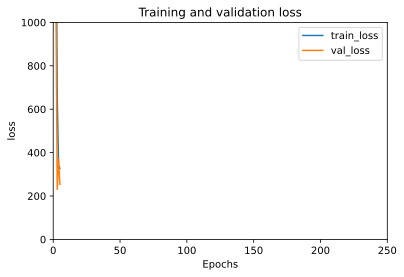

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric, model_name):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.ylim(0,1000)
    plt.xlim(0,250)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.savefig(str(model_name) + '.pdf')
    plt.show()

fig = plot_metric(history, 'loss', str(model_name))

#### Ploting the predictions

Training rmse: 16.45  and Testing rmse: 15.2 and Hold rmse: 12.79
Training R2: -0.06  and Testing R2: 0.04 and Hold R2: 0.04


Text(0.5, 1.0, 'Time Taken in mins:0.41')

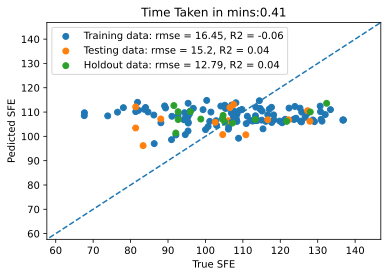

In [9]:
saved_model = load_model(str(model_name) + '.hdf5')

#Plotting the predicted values from the model
train_prediction = saved_model.predict(train_desc)
test_prediction = saved_model.predict(test_desc)
hold_prediction = saved_model.predict(hold_desc)

#RMSE and R2
train_rmse = round(math.sqrt(mse(train_target, train_prediction)),2)
test_rmse = round(math.sqrt(mse(test_target, test_prediction)),2)
hold_rmse = round(math.sqrt(mse(hold_target, hold_prediction)),2)

train_r2 = round(r2_score(train_target, train_prediction),2)
test_r2 = round(r2_score(test_target, test_prediction),2)
hold_r2 = round(r2_score(hold_target, hold_prediction),2)

print(f'Training rmse: {train_rmse}  and Testing rmse: {test_rmse} and Hold rmse: {hold_rmse}\nTraining R2: {train_r2}  and Testing R2: {test_r2} and Hold R2: {hold_r2}')

#Making scatter plots
plt.plot([np.min(SFEs)-20,np.max(SFEs)+20],[np.min(SFEs)-20,np.max(SFEs)+20], '--')
plt.scatter(train_target, train_prediction, label = f'Training data: rmse = {train_rmse}, R2 = {train_r2}')
plt.scatter(test_target, test_prediction, label = f'Testing data: rmse = {test_rmse}, R2 = {test_r2} ')
plt.scatter(hold_target, hold_prediction, label = f'Holdout data: rmse = {hold_rmse}, R2 = {hold_r2} ')
plt.xlabel('True SFE')
plt.ylabel('Pedicted SFE')
plt.legend(loc = 2)
plt.xlim(np.min(SFEs) - 10, np.max(SFEs) + 10)
plt.ylim(np.min(SFEs) - 10, np.max(SFEs) + 10)
plt.title('Time Taken in mins:' + str(time_taken))